In [ ]:
import torch 
import torch.nn as nn
from tokenizers import Tokenizer , models, trainers, pre_tokenizers
from tokenizers.pre_tokenizers import Whitespace
import torch.optim as optim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
corpus = [ 
    " apple mango fruit",
    "car bus vehicle",
    "apple car mango bus",
    "fruit vehicle"
]

In [ ]:
with open("corpus_1.txt", "w", encoding = "utf-8") as f:
    for line in corpus:
        f.write(line + '\n')

In [ ]:
#Train BPE Tokenizer
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizers = Whitespace()
trainer = trainers.BpeTrainer(vocab_size = 100 , show_progress = True, special_tokens = ["[UNK]", "[CLS]", "[SEP]"])
tokenizer.train(["corpus_1.txt"], trainer)

output  = tokenizer.encode("apple car mango")
print("TOKENS : ", output.tokens)
print("TOKEN_ids : ", output.ids)

TOKENS :  ['apple car', ' mango']
TOKEN_ids :  [55, 48]


In [ ]:
# Embeddings
vocab_size = tokenizer.get_vocab_size()
embed_dim = 8 
embedding = nn.Embedding(vocab_size, embed_dim)
token_ids = torch.tensor(output.ids)
embeds = embedding(token_ids)

print("Embeddding Shape :", embeds.shape)
print('Sample Embeddibngs:\n', embeds)

Embeddding Shape : torch.Size([2, 8])
Sample Embeddibngs:
 tensor([[ 1.3305,  1.0911, -1.4215, -1.0234,  0.0856, -1.2968, -0.0760,  1.0882],
        [ 1.1488, -1.1879,  2.6348, -1.2945, -0.1190,  0.7636,  1.2042, -1.1043]],
       grad_fn=<EmbeddingBackward0>)


In [ ]:
# Transfomer
class MiniTransfomer(nn.Module):
    def __init__(self, embed_dim , num_heads = 2):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim , num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim,embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim,embed_dim)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1) # seq length , batch , embed_dim
        attn_out, _ = self.attn(x,x,x)
        x= attn_out + x # residual 
        x = self.ff(x)+x
        return x.squeeze(1)

model = MiniTransfomer(embed_dim)

In [ ]:
#Training loop 
optimizer = optim.Adam(list(model.parameters())  + list(embedding.parameters()), lr= 0.01  ) 
loss_fn = nn.CrossEntropyLoss()

for epoch in range(10):
    optimizer.zero_grad()

    # recomute embeddings each epoch
    embeds = embedding(token_ids)
    inputs = embeds[:-1]
    targets = token_ids[1:]

    out = model(inputs)
    logits = out @ embedding.weight.T
    loss = loss_fn(logits,targets )

    loss.backward()
    optimizer.step()

    print(f"\n Epoch {epoch}")
    print("Transformer Output shape: ", out.shape)
    print("logits  shape: ", logits.shape)
    print("loss:", loss.item())


 Epoch 0
Transformer Output shape:  torch.Size([1, 8])
logits  shape:  torch.Size([1, 63])
loss: 16.75734519958496

 Epoch 1
Transformer Output shape:  torch.Size([1, 8])
logits  shape:  torch.Size([1, 63])
loss: 14.669830322265625

 Epoch 2
Transformer Output shape:  torch.Size([1, 8])
logits  shape:  torch.Size([1, 63])
loss: 12.85169506072998

 Epoch 3
Transformer Output shape:  torch.Size([1, 8])
logits  shape:  torch.Size([1, 63])
loss: 11.143856048583984

 Epoch 4
Transformer Output shape:  torch.Size([1, 8])
logits  shape:  torch.Size([1, 63])
loss: 9.542154312133789

 Epoch 5
Transformer Output shape:  torch.Size([1, 8])
logits  shape:  torch.Size([1, 63])
loss: 7.976885795593262

 Epoch 6
Transformer Output shape:  torch.Size([1, 8])
logits  shape:  torch.Size([1, 63])
loss: 6.483832836151123

 Epoch 7
Transformer Output shape:  torch.Size([1, 8])
logits  shape:  torch.Size([1, 63])
loss: 5.092406272888184

 Epoch 8
Transformer Output shape:  torch.Size([1, 8])
logits  shape:

) missing from current font.Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


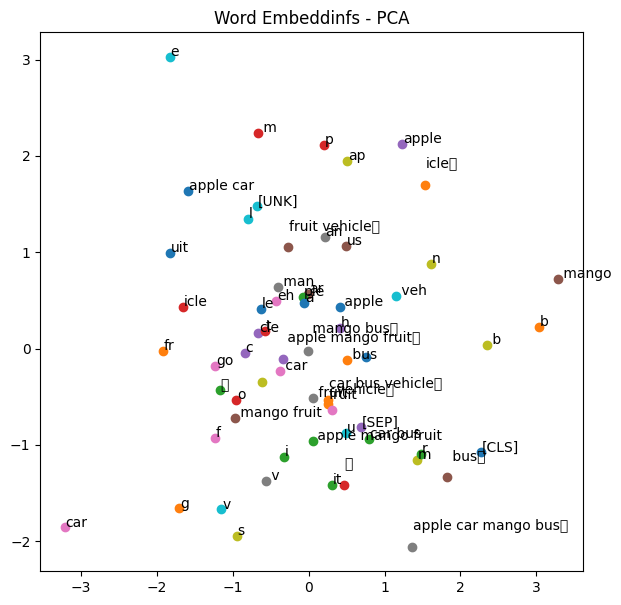

In [ ]:
# Visulaize

final_embeds = embedding.weight.detach().numpy()

pca = PCA(n_components=2).fit_transform(final_embeds)

plt.figure(figsize= (7,7))

for word, idx in tokenizer.get_vocab().items():
    plt.scatter(pca[idx, 0], pca[idx,1])
    plt.text(pca[idx,0]+0.01, pca[idx,1]+0.01, word)
    plt.title("Word Embeddinfs - PCA")
plt.show()
